In [21]:
import cvxpy as cp
import numpy as np


# First, we write the function for creating box
# This is the code to make a box around a vector v = [v1 v2 ... vn]^T with parameters r = [r1 r2 ... rn]^T
def make_box(v, r):
    n = len(v)
    zeros = [0]*(n+1)
    mat = []
    # Adding the constraints for positive values
    for r1 in r:
        zeros[0] = r1
        mat.append(zeros*1)
    # Adding the constraints for negative values
    for r1 in r:
        zeros[0] = r1
        mat.append(zeros*1)   
    # print('mat zeros = ', mat) # [[0.1,0,0], [0.1,0,0], [0.1,0,0], [0.1,0,0]]
    
    for i in range(n):
        mat[i][i+1] = 1 # [[0.1,1,0], [0.1,0,1], [0.1,0,0], [0.1,0,0]]
    # print('mat pos = ', mat)
    j = 1
    for i in range(n,2*n):
        mat[i][j] = -1 # # [[0.1,1,0], [0.1,0,1], [0.1,-1,0], [0.1,0,-1]]
        j += 1
    # print('mat for constraints = ', mat)
    Box = Polyhedron(ieqs=mat, backend='ppl', base_ring=QQ)
    return Box

# We write a function to compute minimum distance between two polyhedra, and return the points
def min_dist_between_polyhedra(P1, P2):
    # At first, we extract the linear constraints from both polyhedra written as Ax + b >= 0
    Ab1 = list(P1.Hrepresentation())
    Ab2 = list(P2.Hrepresentation())
    b1, A1 = ([a[0] for a in Ab1], [a[1:] for a in Ab1])
    b2, A2 = ([a[0] for a in Ab2], [a[1:] for a in Ab2])
    b1, A1, b2, A2 = np.array(b1), np.array(A1), np.array(b2), np.array(A2)
    # print('b1 = ', b1)
    # print('A1 = ', A1)
    # print('b2 = ', b2)
    # print('A2 = ', A2)

    # The dimension of the polyhedra are the number of columns in Matrix A
    n = len(A1[0])
    print('n = ', n)

    # We define two vectors of same dimensions
    X1 = cp.Variable(n)
    X2 = cp.Variable(n)

    # Next, we write the constraints for the two polyhedra P1 and P2 such that vector X1 in P1 and X2 in P2
    constraints = [A1@X1 >= -b1, A2@X2 >=-b2]

    # Finally, we write the objective function which is to minimize the infinity norm of any two points in P1 and P2
    objective = cp.Minimize(cp.norm_inf(X1-X2))

    # Problem formulation
    prob = cp.Problem(objective, constraints)

    # Solve the problem
    prob.solve()

    # Finally, we have the minimum distance and the two vectors,
    val, x1, x2 = prob.value, X1.value, X2.value
    # print('Minimum distance = ', val)
    # print('Vector in P1 = ', x1)
    # print('Vector in P2', x2)
    return val, x1, x2

# Next, we write a function to compute the maximum distance of a vector and a polyhedron
def max_dist_vector_to_polyhedron(v, P):
    X = P.vertices_list()
    dist_list = [(np.linalg.norm(v-x), x) for x in X]
    d, vx = max(dist_list)
    return d, vx

# We will describe a simple 2D example. First we define the initial state and the initial input
# X = [x y] is a state in 2D
# U = [u] is an input in 1D
X0 = Polyhedron(ieqs=[(-1,0,1),(4,0,-1),(-2,3,-1),(2,-1,1)], backend='ppl', base_ring=QQ)
U0 = Polyhedron(eqns=[(-3,1)], backend='ppl', base_ring=QQ)

# Since we have X in 2D and U in 1D, A will be a 2x2 matrix, B will be a 2x1 matrix, and K will be a 1x2 matrix
A = Matrix([[1,2],[3,4]])
B = Matrix([[0],[1]])
K = Matrix([-3, -5])

# The dimension and epsilon for the box
n, ep = 2, 0.2
u = 1

# Parameters for alg3
T0 = [2,9]
W = Polyhedron(ieqs=[(-10,0,1),(40,0,-1),(-20,3,-1),(20,-1,1)], backend='ppl', base_ring=QQ)
c = 1
C = A*0.5
D = B*2
E = Polyhedron(vertices=[[2,1]])

print(C)
print(D)


[0.500000000000000  1.00000000000000]
[ 1.50000000000000  2.00000000000000]
[0]
[2]


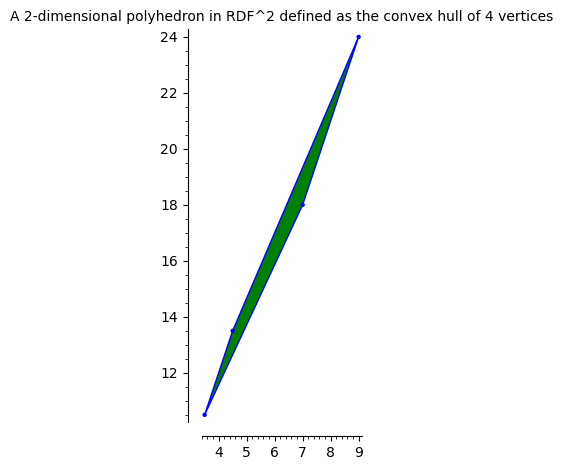

In [12]:
ans = C*X0+D*U0+E
ans

In [15]:
X = X0 & W
X.vertices_list()

[]

n =  2
ValueError =  *Error: Numerical inconsistency is found.  Use the GMP exact arithmetic.
ValueError =  *Error: Numerical inconsistency is found.  Use the GMP exact arithmetic.


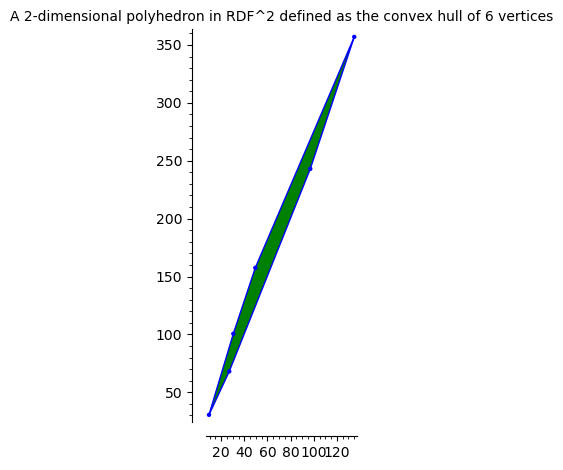

In [23]:
# Create the box
v = [0]*n
r = [ep]*n
Box = make_box(v,r)


Xc = X0
Uc = U0
l, u = T0[0], T0[1]
iter = 3
for i in range(iter):
    try:
        Al = A*l
        Bl = B*l
        AlXc = Al*Xc
        BlUc = Bl*Uc
        X1 = AlXc+BlUc
        Au = A*u
        Bu = B*u
        X2 = Au*Xc + Bu*Uc
        x1v = [list(x1) for x1 in X1.vertices()]
        x2v = [list(x2) for x2 in X2.vertices()]
        X3 = Polyhedron(vertices=(x1v+x2v)) # Convex hull of X1, X2
        Xc = X3 + C*Xc + D*Uc + E
        size = c/l
        v, r = [0]*n, [size]*n
        Xh = Xc + make_box(v, r)
        Uc = K*Xh
        # CVX tool steps
        l, x1, w1 = min_dist_between_polyhedra(Xh, W)
        u, x2 = max_dist_vector_to_polyhedron(w1, Xh)
        Xw = Xc & W

        if (Xw.vertices_list()):
            print(Xw)
            print("Unsafe state reached!!!")
            break
    except ValueError as ve:
        print('ValueError = ', ve)

Xc